#災害データ分析
今回はEM-DATの災害データセットを利用して、世界中の災害についてグラフや図にまとめてそれぞれの関連性などを考察していきます。

このEM-DAT災害データは1900年から2024年までの世界で起きた自然災害の状況をまとめたデータです。

まずは、EM-DATデータを読み込んでいきます。

In [41]:
!pip install plotly



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime


# 表示設定
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

In [43]:
DATA_PATH = 'data/emdat.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"EM-DAT データファイルが見つかりません: {DATA_PATH}\n"
        "Please download the EM-DAT CSV and place it at this path."
    )

df = pd.read_csv(DATA_PATH, encoding='utf-8')

# 最初の数行を表示
print(f"読み込んだ行数: {len(df)}")
df.head()


読み込んだ行数: 17278


,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Subregion,Region,Latitude,Longitude,Start Year,Total Deaths
0,Meteorological,Storm,Tropical cyclone,USA,United States of America,Northern America,Americas,NaN,NaN,1900,6000.0
1,Hydrological,Flood,Flood (General),JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,300.0
2,Biological,Epidemic,Viral disease,JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,30.0
3,Geophysical,Volcanic activity,Ash fall,JPN,Japan,Eastern Asia,Asia,NaN,NaN,1900,30.0
4,Geophysical,Earthquake,Ground movement,TUR,Türkiye,Western Asia,Asia,40.3,43.1,1900,140.0


In [44]:
print('columns:', df.columns.tolist())


# よくあるカラム（データセットのバージョンにより名前が異なる可能性があります）
# 例: 'Year', 'Country', 'Disaster Type', 'Subgroup', 'Total deaths', 'No. affected', 'Total affected', 'Total damages (US$)'


# カラム名を標準化（存在するものだけに対応）
col_map = {
'Year': 'year',
'Country': 'country',
'Disaster Type': 'disaster_type',
'Disaster Subgroup': 'disaster_subtype',
'Event Name': 'event_name',
'Total deaths': 'deaths',
'No. affected': 'no_affected',
'Total affected': 'total_affected',
'Total damages (US$)': 'damages_usd'
}


# 既存のカラム名に合わせてキーを選択
existing_map = {k:v for k,v in col_map.items() if k in df.columns}


# rename
if existing_map:df = df.rename(columns=existing_map)


# 共通で扱うカラムだけ選択（存在するもの）
use_cols = [v for v in col_map.values() if v in df.columns]
df = df[use_cols + [c for c in df.columns if c not in use_cols]]


# 型変換
if 'year' in df.columns:df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce').dt.year


for col in ['deaths', 'no_affected', 'total_affected', 'damages_usd']:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace('[,\$ ]', '', regex=True)
            .replace('', np.nan)
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')



# 確認
print('前処理後の行数:', len(df))
df.info()

columns: ['Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'ISO', 'Country', 'Subregion', 'Region', 'Latitude', 'Longitude', 'Start Year', 'Total Deaths']
前処理後の行数: 17278
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17278 entries, 0 to 17277
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           17278 non-null  object 
 1   disaster_type     17278 non-null  object 
 2   disaster_subtype  17278 non-null  object 
 3   Disaster Subtype  17278 non-null  object 
 4   ISO               17278 non-null  object 
 5   Subregion         17278 non-null  object 
 6   Region            17278 non-null  object 
 7   Latitude          2797 non-null   float64
 8   Longitude         2797 non-null   float64
 9   Start Year        17278 non-null  int64  
 10  Total Deaths      12332 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.5+ MB


<>:44: SyntaxWarning:

invalid escape sequence '\$'

<>:44: SyntaxWarning:

invalid escape sequence '\$'

C:\Users\ukazu\AppData\Local\Temp\ipykernel_7072\3585472640.py:44: SyntaxWarning:

invalid escape sequence '\$'



次に1900年から2024年までに世界で起きた自然災害の数を折れ線グラフにまとめていきます。

In [45]:
# year列を作成（Start Year を使う）
if 'Start Year' in df.columns:
    df['year'] = pd.to_numeric(df['Start Year'], errors='coerce')
else:
    raise ValueError("Start Year 列がありません。列名を確認してください。")

# Total Deaths を数値に変換
if 'Total Deaths' in df.columns:
    df['deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce')
else:
    df['deaths'] = np.nan  # ない場合は空にする


In [46]:
yearly = df.groupby('year').agg(
    events=('year', 'count'),
    deaths=('deaths', 'sum')
).reset_index()

display(yearly.head())


,year,events,deaths
0,1900,7,1267500.0
1,1901,2,200018.0
2,1902,10,48438.0
3,1903,12,7136.0
4,1904,4,152.0


In [47]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'   # ← これを追加


In [48]:
!pip install nbformat


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import plotly.io as pio
pio.renderers.default = "vscode"


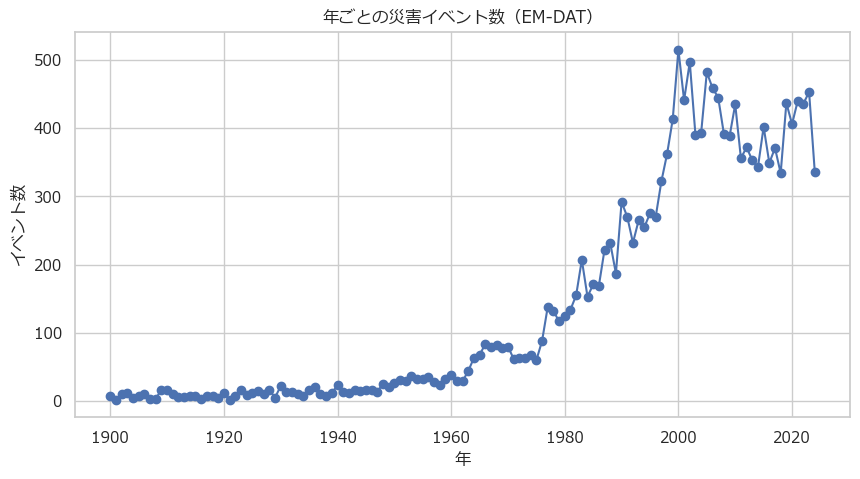

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(yearly['year'], yearly['events'], marker='o')
plt.title('年ごとの災害イベント数（EM-DAT）')
plt.xlabel('年')
plt.ylabel('イベント数')
plt.grid(True)

plt.show()


このグラフで示されているイベント数は自然災害の数を指します。
グラフを見ると1980年代から災害数が増加していることから、自然災害の察知や情報収集が本格的に行われ始めたのがこのころからだというのが考えられます。
また、2000年代からは災害数が交互に上下していることがわかります。

次は自然災害数TOP10の国々の比較や1位の国の年代別災害発生数をグラフにして見比べていきます。

In [51]:
df.columns


Index(['country', 'disaster_type', 'disaster_subtype', 'Disaster Subtype',
       'ISO', 'Subregion', 'Region', 'Latitude', 'Longitude', 'Start Year',
       'Total Deaths', 'year', 'deaths'],
      dtype='object')

In [52]:
import matplotlib.font_manager as fm
for f in fm.findSystemFonts():
    print(f)


C:\Windows\Fonts\ENGR.TTF
C:\Windows\Fonts\BELL.TTF
C:\Windows\Fonts\malgunsl.ttf
C:\Windows\Fonts\BIZ-UDGothicR.ttc
C:\Windows\Fonts\ROCK.TTF
C:\Windows\Fonts\ARLRDBD.TTF
C:\Windows\Fonts\NIAGENG.TTF
C:\Windows\Fonts\webdings.ttf
C:\Windows\Fonts\NIAGSOL.TTF
C:\Windows\Fonts\PAPYRUS.TTF
C:\Windows\Fonts\framd.ttf
C:\Windows\Fonts\BIZ-UDMinchoM.ttc
C:\Windows\Fonts\wingding.ttf
C:\Windows\Fonts\RAVIE.TTF
C:\Windows\Fonts\Candara.ttf
C:\Windows\Fonts\ROCC____.TTF
C:\Windows\Fonts\meiryob.ttc
C:\Windows\Fonts\COPRGTL.TTF
C:\Windows\Fonts\GIL_____.TTF
C:\Windows\Fonts\NotoSansJP-VF.ttf
C:\Windows\Fonts\LATINWD.TTF
C:\Windows\Fonts\segoeuil.ttf
C:\Windows\Fonts\cambriaz.ttf
C:\Windows\Fonts\ROCCB___.TTF
C:\Windows\Fonts\SHOWG.TTF
C:\Windows\Fonts\CALIFR.TTF
C:\Windows\Fonts\BKANT.TTF
C:\Windows\Fonts\TCBI____.TTF
C:\Windows\Fonts\ebrimabd.ttf
C:\Windows\Fonts\COOPBL.TTF
C:\Windows\Fonts\segoescb.ttf
C:\Windows\Fonts\HATTEN.TTF
C:\Windows\Fonts\cambriab.ttf
C:\Windows\Fonts\VINERITC.TTF
C:\

In [53]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 日本語フォント（Noto Sans JP）を強制適用 ---
font_path = r"C:\Windows\Fonts\NotoSansJP-VF.ttf"
jp_font = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = jp_font.get_name()
plt.rcParams['font.sans-serif'] = [jp_font.get_name()]
plt.rcParams['axes.unicode_minus'] = False


読み込んだ行数: 17278


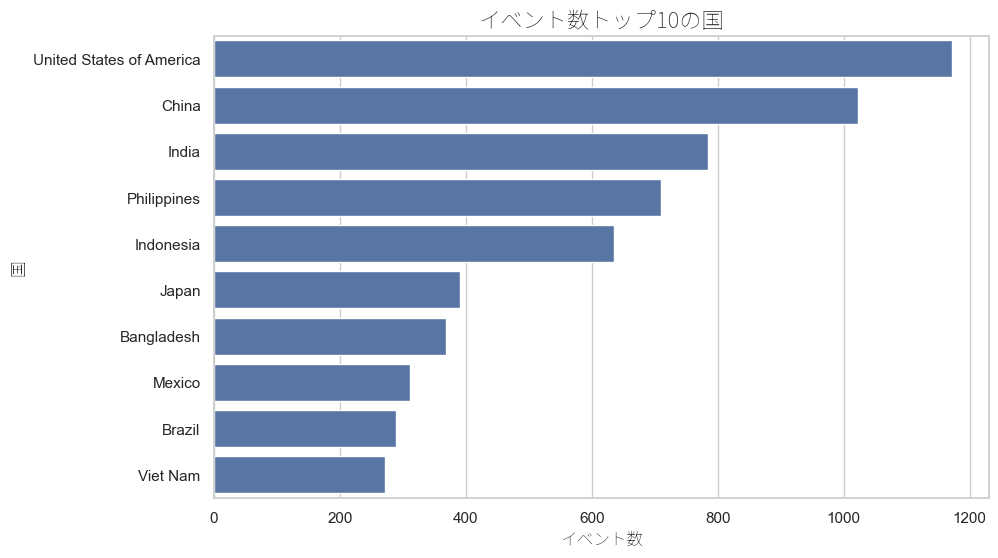

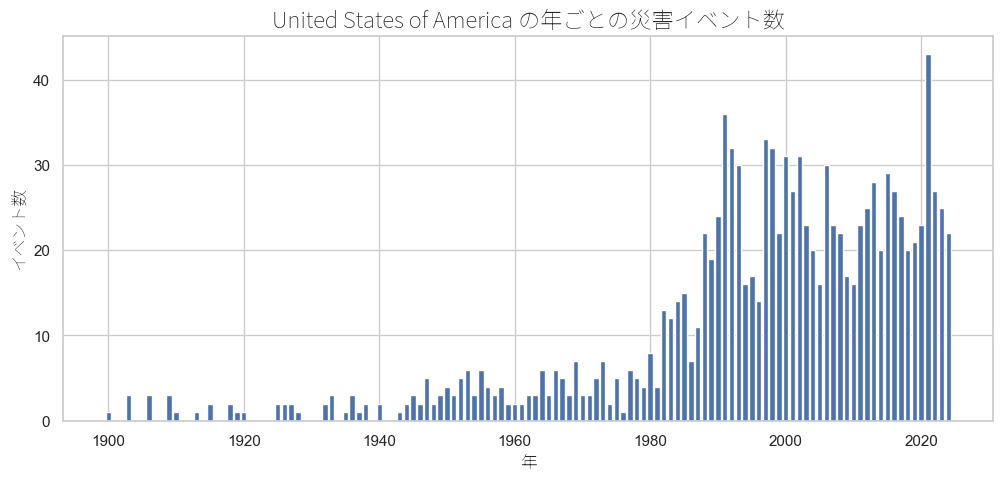

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from datetime import datetime

# ========================
# 日本語フォント設定（Noto Sans JP）
# ========================
font_path = r"C:\\Windows\\Fonts\\NotoSansJP-VF.ttf"
jp_font = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = jp_font.get_name()
plt.rcParams['font.sans-serif'] = [jp_font.get_name()]
plt.rcParams['axes.unicode_minus'] = False

sns.set(style="whitegrid")  # フォントは指定しない（rcParams を使う）

# ========================
# データ読み込み
# ========================
DATA_PATH = "data/emdat.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"EM-DAT データファイルが見つかりません: {DATA_PATH}\n"
        "data フォルダに emdat.csv を保存してください。"
    )

df = pd.read_csv(DATA_PATH, encoding='utf-8')
print(f"読み込んだ行数: {len(df)}")

# ========================
# カラム名の統一
# ========================
col_map = {
    'Year': 'year',
    'Country': 'country',
    'Disaster Type': 'disaster_type',
    'Disaster Subgroup': 'disaster_subtype',
    'Event Name': 'event_name',
    'Total deaths': 'deaths',
    'No. affected': 'no_affected',
    'Total affected': 'total_affected',
    'Total damages (US$)': 'damages_usd'
}

existing_map = {k: v for k, v in col_map.items() if k in df.columns}
df.rename(columns=existing_map, inplace=True)

# 数値に変換
for col in ['deaths', 'no_affected', 'total_affected', 'damages_usd']:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace('[,\\$ ]', '', regex=True)
            .replace('', np.nan)
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ========================
# 年ごとの災害イベント数
# ========================
if 'year' in df.columns:
    yearly = df.groupby('year').agg(
        events=('year', 'count'),
        deaths=('deaths', 'sum'),
        damages=('damages_usd', 'sum')
    )

    # ---- イベント数 ----
    plt.figure(figsize=(12, 5))
    plt.plot(yearly.index, yearly['events'])
    plt.title('年ごとの災害イベント数', fontproperties=jp_font, fontsize=16)
    plt.xlabel('年', fontproperties=jp_font)
    plt.ylabel('イベント数', fontproperties=jp_font)
    plt.show()

    # ---- 死亡数 ----
    if 'deaths' in yearly.columns:
        plt.figure(figsize=(12, 5))
        plt.plot(yearly.index, yearly['deaths'])
        plt.title('年ごとの災害による死亡数（合計）', fontproperties=jp_font, fontsize=16)
        plt.xlabel('年', fontproperties=jp_font)
        plt.ylabel('死亡者数', fontproperties=jp_font)
        plt.show()

# ========================
# 国別トップ10（イベント数）
# ========================
if 'country' in df.columns:
    top_events = df.groupby('country').size().sort_values(ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_events.values, y=top_events.index)
    plt.title('イベント数トップ10の国', fontproperties=jp_font, fontsize=16)
    plt.xlabel('イベント数', fontproperties=jp_font)
    plt.ylabel('国', fontproperties=jp_font)
    plt.show()

# ========================
# 災害タイプ別の年間推移（過去30年）
# ========================
if 'disaster_type' in df.columns and 'year' in df.columns:
    type_year = df.groupby(['year', 'disaster_type']).size().reset_index(name='count')

    recent_years = df['year'].max() - 30
    recent = type_year[type_year['year'] >= recent_years]

    plt.figure(figsize=(12, 6))
    for dtype in recent['disaster_type'].unique():
        subset = recent[recent['disaster_type'] == dtype]
        plt.plot(subset['year'], subset['count'], label=dtype)

    plt.title('災害タイプ別のイベント数（過去30年）', fontproperties=jp_font, fontsize=16)
    plt.xlabel('年', fontproperties=jp_font)
    plt.ylabel('イベント数', fontproperties=jp_font)
    plt.legend(prop=jp_font)
    plt.show()

# ========================
# 国ごとの時系列例（最頻出国）
# ========================
if 'country' in df.columns:
    sample_country = df['country'].dropna().mode().iloc[0]
    country_df = df[df['country'] == sample_country]

    if 'Start Year' in country_df.columns:
        country_year = country_df.groupby('Start Year').agg(events=('Start Year', 'count')).reset_index()

        plt.figure(figsize=(12, 5))
        plt.bar(country_year['Start Year'], country_year['events'])
        plt.title(f'{sample_country} の年ごとの災害イベント数', fontproperties=jp_font, fontsize=16)
        plt.xlabel('年', fontproperties=jp_font)
        plt.ylabel('イベント数', fontproperties=jp_font)
        plt.show()

これらのグラフから自然災害の数一位がアメリカ、二位が中国、三位がインドであることがわかります。私たちの住む日本は6位となっています。
アメリカの災害数の多さはこのEM-DATデータの集計を行っている国であることや東西が海に面していて、その海岸沿いに首都があることでハリケーンが多く観測されているなどの影響が考えられます。

また、アメリカの災害数のグラフからは2021年が特に多くの災害数を観測していることがわかります。
この年はストームの観測数が多いだけでなく、森林火災も多く観測されていてとても乾燥していたことが考えられます。

#まとめ（感想、学んだこと）
グラフで災害数についてまとめたことで、災害数が多い国には次の共通点があることが分かった。
１．地理的に大きな国土を持つ国
２．プレートの真上にある国
３．砂漠地帯など乾燥地帯を持つ国
４．海に面しており、海や風の影響を受けやすい国
これらの災害大国はいつ、どのような形で自然災害による大打撃を受けるかわからないため、特に連携、協力に励み、助け合いをしていくべきであると感じた。
また、想像よりも火災による死者数が多く驚いた。